In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = 'customer_booking.csv'

In [7]:
import chardet

with open('customer_booking.csv', 'rb') as rawdata:
  result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [8]:
df = pd.read_csv(data, encoding='ISO-8859-1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# **Exploratory Data Analysis**

In [9]:
# checking for datatypes and null value count in the dataset

df.info()

# there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [10]:
# checking for count of rows and columns

df.shape
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [12]:
df.booking_complete.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

# **Mutual Information**

In [13]:
X = df.drop('booking_complete', axis=1)
y = df.booking_complete

# changing dtype object to int64
for colname in X.select_dtypes("object"):
  X[colname], _ = X[colname].factorize()

In [14]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [15]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)


mi_scores    # showing features with their mi scores

num_passengers           0.003417
sales_channel            0.000883
trip_type                0.000874
purchase_lead            0.001585
length_of_stay           0.005683
flight_hour              0.001198
flight_day               0.000000
route                    0.054284
booking_origin           0.048685
wants_extra_baggage      0.009396
wants_preferred_seat     0.004177
wants_in_flight_meals    0.001826
flight_duration          0.016859
Name: MI Scores, dtype: float64

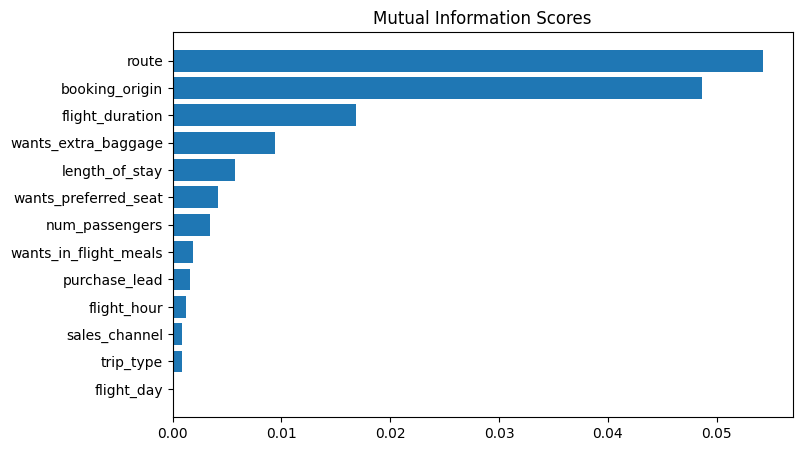

In [17]:
def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Top 5 features that are dependent with booking_complete feature are:



1.   route
2.   booking_origin
3.   flight_duration
4.   wants_extra_baggage
5.   length_of_stay



In [21]:
# train test split

from sklearn.model_selection import train_test_split

# creating a function to split dataset
def dataset(X, y):
  train_full_X, val_X, train_full_y, val_y = train_test_split(X, y, test_size=0.2, random_state=20)
  train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25, random_state=30)
  return(train_X, val_X, train_y, val_y)

In [22]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler scales down the outliers to a fixed range

def scale(X):
  scaler = MinMaxScaler()
  scaler.fit(X)
  return X

# Model 1 : Random forest classifier with top 6 features

In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# assigning the features under a list
features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X = df[features]

# one hot encoding
X = pd.get_dummies(X, columns=features)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

forest_model = RandomForestClassifier(random_state=10)
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_val)

print("Accuracy Score: ",accuracy_score(y_val, preds)*100)
print("AUC Score: ", roc_auc_score(y_val, preds))

Accuracy Score:  83.28
AUC Score:  0.5636378987442817


# Model 2 : Random forest classifier with all features

In [28]:
X = df.drop('booking_complete', axis=1)
# one hot encoding
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

forest_model = RandomForestClassifier(random_state=12)
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_val)

print("Accuracy Score: ", accuracy_score(y_val, preds)*100)
print("AUC Score: ", roc_auc_score(y_val, preds))

Accuracy Score:  84.78
AUC Score:  0.550726106045255


# Model 3 : XGB classifier with top 6 features


In [29]:
from xgboost import XGBClassifier

X = df[features]

# one hot encoding
X = pd.get_dummies(X, columns=features)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("Accuracry Score: ", accuracy_score(y_val, xgb_preds)*100)
print("AUC Score: ", roc_auc_score(y_val, xgb_preds))

Accuracry Score:  84.5
AUC Score:  0.5233106137361457


# Model 4 : XGB classifier with all features

In [30]:
X = df.drop('booking_complete', axis=1)
# one hot encoding
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

X_train, X_val, y_train, y_val = dataset(X, y)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("Accuracy Score: ", accuracy_score(y_val, xgb_preds)*100)
print("AUC Score: ", roc_auc_score(y_val, xgb_preds))

Accuracy Score:  84.59
AUC Score:  0.5387146541401862


Finalizing Random Forest Clasifier model with all features as it has good accuracy and higher auc score compared to other models.
Validating with the test data

In [32]:
X = df.drop('booking_complete', axis=1)
# one hot encoding
X = pd.get_dummies(X)
X = scale(X)
y = df.booking_complete

train_full_X, test_X, train_full_y, test_y = dataset(X, y)

forest_model = RandomForestClassifier()
forest_model.fit(train_full_X, train_full_y)
preds = forest_model.predict(test_X)

print("Accuracy Score: ", accuracy_score(test_y, preds)*100)
print("AUC Score:", roc_auc_score(test_y, preds))

Accuracy Score:  84.86
AUC Score: 0.5522612139633416
